# For an analysis competition...
What to predict?
- age ... too few nans (prediction may be meaningless...)
- cancellation of premium membership

# Libraries

In [1]:
# basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import time
import datetime
import os
import sys
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
import plotly.figure_factory as ff
import plotly.express as px
import missingno as msno

sns.set_context("talk")
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
style.use('fivethirtyeight')

# custom EDA functions
mypath = os.getcwd()
sys.path.append(mypath + '/code/') 
from utils import reduce_mem_usage, plot_target
from categorical_encoder import label_encoding
from feature_converter import categorize_features
from catplot import CategoricalVisualizer
from denseplot import DenseVisualizer

# custom modeling functions
sys.path.append(mypath + '/cls_models/') 
from base_classifier import ClassifierBase
from lgb_classifier import LgbClassifier
from catb_classifier import CatbClassifier

# stats
from scipy import stats
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import train_test_split
import scipy as sp
from functools import partial
from collections import Counter

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

print("libraries imported")

libraries imported


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



# Load data

In [2]:
!ls

EDA.ipynb            EDA_titanic.ipynb    inputs
EDA_houseprice.ipynb cls_models           reg_models
EDA_laputa.ipynb     code


In [3]:
# check path
datapath = "inputs/"
datapath = "/Volumes/sec/anemos-poc-large-sec/users/kakawagu/data/laputa_comp"
files = os.listdir(datapath)
print(files)

['laputa.csv']


In [4]:
# import data
time0 = time.time()

train = pd.read_csv(datapath + '/laputa.csv', index_col=0)
# test = pd.read_csv(datapath + '/test.csv')
# submission = pd.read_csv(datapath + '/sample_submission.csv')

time1 = time.time()
print(time1 - time0, " seconds to load data")

17.43032193183899  seconds to load data


In [5]:
# check train
print(train.shape)
train.head()

(10000, 1021)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,1_y_id_master_chkyj_flag,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,000081BEB28F85B6DE,2,NaN,20140518,20140525.0,20191201,37.0,67,289,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.057251
1,0000DC88EA731D5BFC,1,NaN,20030216,20080701.0,20191201,38.0,202,876,False,...,NaN,NaN,NaN,NaN,0.022498,NaN,NaN,NaN,0.013953,0.002430
2,0000D9F6A83EA4C67C,2,NaN,20160424,20160426.0,20191130,38.0,44,188,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00088B68DFA836DEBE,1,NaN,20150111,20150116.0,20191119,28.0,59,255,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0007596AE753E853D9,1,NaN,20190901,20190905.0,20191104,23.0,3,13,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 1021 entries, y_id_hex to 99_yup_user_daily_score_2_interest_know_well_construction
dtypes: bool(6), float64(911), int64(17), object(87)
memory usage: 77.6+ MB


In [7]:
train.dtypes

y_id_hex                                                                           object
1_y_id_master_gender                                                                int64
1_y_id_master_birthday                                                            float64
1_y_id_master_registration_date                                                     int64
1_y_id_master_first_update                                                        float64
1_y_id_master_last_update                                                           int64
1_y_id_master_age                                                                 float64
1_y_id_master_registration_month                                                    int64
1_y_id_master_registration_week                                                     int64
1_y_id_master_chkyj_flag                                                             bool
2_user_profile_master_commerce_registration_month                                   int64
2_user_pro

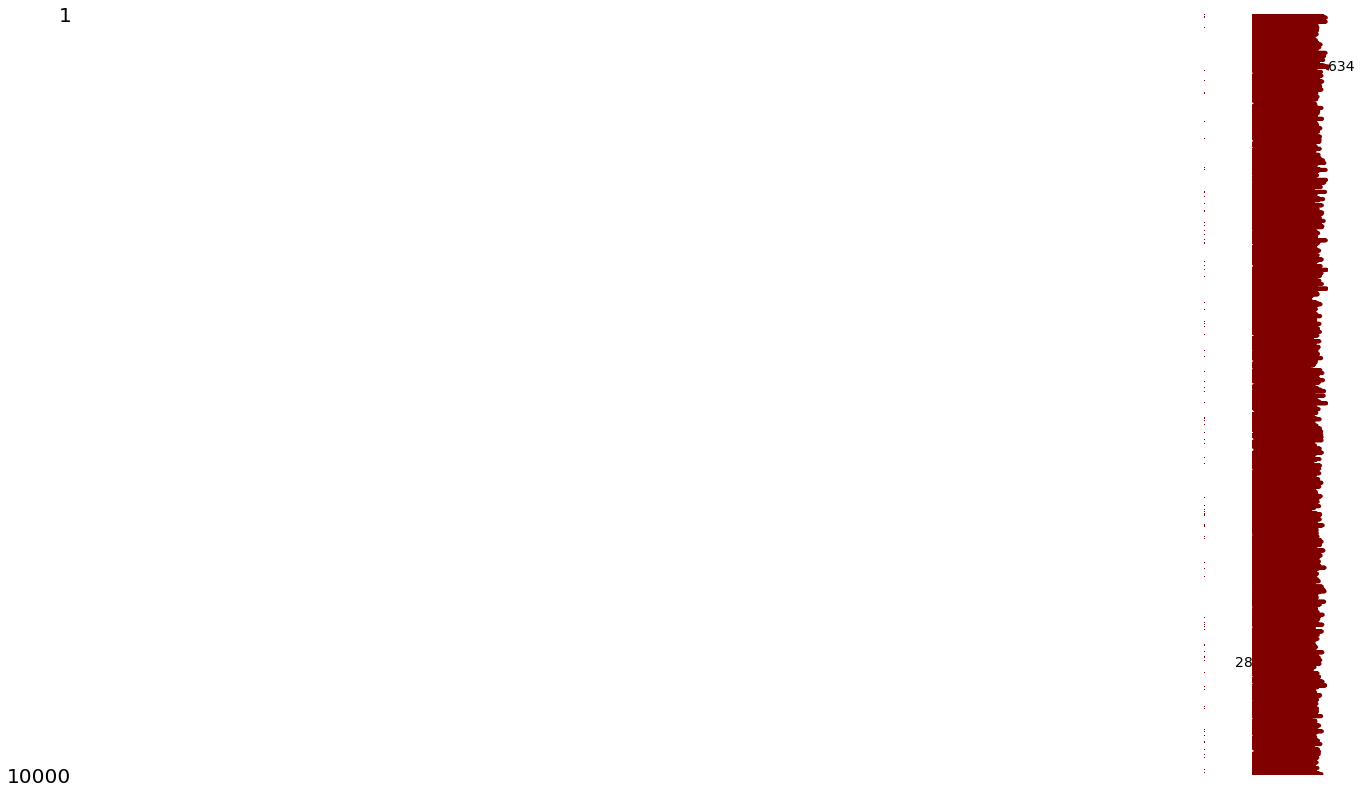

In [8]:
# missing data?
import missingno as msno
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

In [9]:
premium_features = []
for f in train.columns.values.tolist():
    if "premium_user_master" in f:
        premium_features.append(f)
        print(f)

10_premium_user_master_last_order_date
10_premium_user_master_premium_segment_id
10_premium_user_master_service_code
10_premium_user_master_channel_id
10_premium_user_master_campaign_id
10_premium_user_master_discount_id
10_premium_user_master_cancel_flag
10_premium_user_master_cancel_date
10_premium_user_master_cancel_type
10_premium_user_master_registration_day
10_premium_user_master_registration_month
10_premium_user_master_sbm_type
10_premium_user_master_first_order_date
10_premium_user_master_order_count


In [10]:
train[premium_features].head()

,10_premium_user_master_last_order_date,10_premium_user_master_premium_segment_id,10_premium_user_master_service_code,10_premium_user_master_channel_id,10_premium_user_master_campaign_id,10_premium_user_master_discount_id,10_premium_user_master_cancel_flag,10_premium_user_master_cancel_date,10_premium_user_master_cancel_type,10_premium_user_master_registration_day,10_premium_user_master_registration_month,10_premium_user_master_sbm_type,10_premium_user_master_first_order_date,10_premium_user_master_order_count
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20190326.0,2.0,2432.0,C0ymb001,A-140601,800000924.0,False,NaN,NaN,297.0,9.0,0.0,20030707.0,6.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20170601.0,1.0,2419.0,NaN,NaN,800001066.0,True,20180420.0,2.0,0.0,0.0,5.0,20170601.0,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
train["10_premium_user_master_cancel_flag"].dtype

dtype('O')

In [12]:
train["1_y_id_master_age"].isna().sum() / train.shape[0]

0.0218

# Target

In [13]:
# remove nan from target
target = "10_premium_user_master_cancel_flag"
# target = "1_y_id_master_age"
train = train.loc[train[target].isna().values == False, :].reset_index(drop=True, inplace=False)
train[target].value_counts()

False    3018
True     1209
Name: 10_premium_user_master_cancel_flag, dtype: int64

In [14]:
train[target] = train[target].astype(int)
train[target].value_counts()

0    3018
1    1209
Name: 10_premium_user_master_cancel_flag, dtype: int64

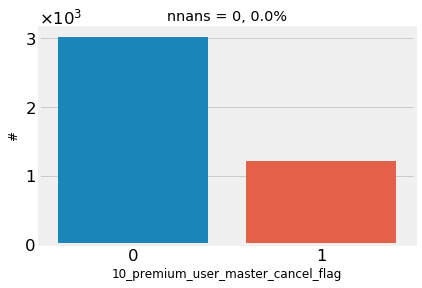

In [15]:
# hist
target = "10_premium_user_master_cancel_flag"
plot_target(train, target, objective="classification")

In [16]:
# roughly categorize features
features, dense_features, cat_features = categorize_features(train, target, cat_threshold=12)

There are 1020 features.
There are 524 dense features.
There are 496 categorical features.


# Train, test split

In [17]:
kf = StratifiedKFold(n_splits=5, random_state=1220, shuffle=True)
for fold, (train_index, test_index) in enumerate(kf.split(train, train[target])):
    if fold == 0:
        X_train, X_test = train.loc[train_index, :], train.loc[test_index, :]
        y_train, y_test = train.loc[train_index, target], train.loc[test_index, target]
    else:
        pass

In [18]:
print(X_train.shape)
X_train.head()

(3381, 1021)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,1_y_id_master_chkyj_flag,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,0000DC88EA731D5BFC,1,NaN,20030216,20080701.0,20191201,38.0,202,876,False,...,NaN,NaN,NaN,NaN,0.022498,NaN,NaN,NaN,0.013953,0.002430
1,00088B68DFA836DEBE,1,NaN,20150111,20150116.0,20191119,28.0,59,255,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0003C8DA499B07FE8C,1,NaN,20170212,20170217.0,20191130,53.0,34,146,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005941
3,00077071089DC5AA3D,1,NaN,20080810,20080814.0,20191201,39.0,136,590,False,...,NaN,NaN,NaN,NaN,NaN,0.026999,NaN,NaN,NaN,NaN
4,0000CFBA992DE7AB41,2,NaN,20170611,20170617.0,20191201,46.0,30,129,False,...,NaN,0.035332,NaN,NaN,NaN,0.006862,NaN,0.032296,NaN,NaN


In [19]:
print(X_test.shape)
X_test.head()

(846, 1021)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,1_y_id_master_chkyj_flag,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
6,00091D0CB89425297A,2,NaN,20170430,20170503.0,20191106,72.0,32,135,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,00088DC755AA1FFBF5,1,NaN,20030420,20080630.0,20191201,46.0,200,867,False,...,NaN,0.062455,0.028861,0.198244,0.070231,0.076969,NaN,NaN,0.123662,NaN
18,0004F7E6A17F349216,1,NaN,20170521,20170526.0,20191117,37.0,31,132,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,0006BD9ADDEA3169CB,1,NaN,20080127,20080629.0,20191201,46.0,143,618,False,...,NaN,NaN,0.046852,0.059086,0.079213,NaN,0.027332,NaN,0.103593,0.004861
30,0007DBDDC929063B09,2,NaN,20150503,20150504.0,20191201,19.0,55,239,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Dense features

In [20]:
vd = DenseVisualizer(train=X_train, test=X_test, features=dense_features, target=target)
chkd = vd.column_checker()

feature name = 1_y_id_master_registration_date
feature name = 1_y_id_master_first_update
feature name = 1_y_id_master_last_update
feature name = 1_y_id_master_age
feature name = 1_y_id_master_registration_month
feature name = 1_y_id_master_registration_week
feature name = 2_user_profile_master_commerce_registration_month
feature name = 2_user_profile_master_commerce_age
feature name = 2_user_profile_master_commerce_preimum_registration_month
feature name = 2_user_profile_master_commerce_wallet_registration_month
feature name = 2_user_profile_master_commerce_shopping_order_count
feature name = 2_user_profile_master_commerce_shopping_avg_total_price
feature name = 2_user_profile_master_commerce_shopping_avg_order_day
feature name = 2_user_profile_master_commerce_shopping_last_order_day
feature name = 2_user_profile_master_commerce_auction_won_count
feature name = 2_user_profile_master_commerce_auction_avg_won_price
feature name = 2_user_profile_master_commerce_auction_avg_won_day
feature

feature name = 8_app_user_monthly_stats_ymail_activate_day
feature name = 8_app_user_monthly_stats_ysmarttool_activate_day
feature name = 8_app_user_monthly_stats_ynaviapp_activate_day
feature name = 8_app_user_monthly_stats_maps_activate_day
feature name = 8_app_user_monthly_stats_sportsnavi_activate_day
feature name = 8_app_user_monthly_stats_ymobile_activate_day
feature name = 8_app_user_monthly_stats_ysmartsecurity_activate_day
feature name = 8_app_user_monthly_stats_yjcal_activate_day
feature name = 8_app_user_monthly_stats_yfiler_activate_day
feature name = 8_app_user_monthly_stats_finance_activate_day
feature name = 8_app_user_monthly_stats_chiebukuro_activate_day
feature name = 8_app_user_monthly_stats_ebookjapan_activate_day
feature name = 8_app_user_monthly_stats_pmall_activate_day
feature name = 8_app_user_monthly_stats_toppage_activate_count
feature name = 8_app_user_monthly_stats_weather_activate_count
feature name = 8_app_user_monthly_stats_transit_activate_count
feature 

feature name = 99_yup_user_daily_score_interest_play_golf
feature name = 99_yup_user_daily_score_interest_ski_and_snowboard
feature name = 99_yup_user_daily_score_interest_running
feature name = 99_yup_user_daily_score_interest_fishing
feature name = 99_yup_user_daily_score_interest_ebook
feature name = 99_yup_user_daily_score_interest_anime
feature name = 99_yup_user_daily_score_interest_movie
feature name = 99_yup_user_daily_score_interest_streaming_service
feature name = 99_yup_user_daily_score_interest_figure
feature name = 99_yup_user_daily_score_interest_online_game
feature name = 99_yup_user_daily_score_interest_traveling
feature name = 99_yup_user_daily_score_interest_disney
feature name = 99_yup_user_daily_score_interest_fortune_telling
feature name = 99_yup_user_daily_score_consumption_hometown_tax
feature name = 99_yup_user_daily_score_consumption_donation
feature name = 99_yup_user_daily_score_attribute_pet_dog
feature name = 99_yup_user_daily_score_attribute_pet_cat
featur

feature name = 99_yup_user_daily_score_2_interest_korea_tv_drama
feature name = 99_yup_user_daily_score_2_interest_variety_tv_show
feature name = 99_yup_user_daily_score_2_interest_shogi
feature name = 99_yup_user_daily_score_2_interest_qualifying_exam
feature name = 99_yup_user_daily_score_2_interest_studying_english
feature name = 99_yup_user_daily_score_2_interest_audio_equipment
feature name = 99_yup_user_daily_score_2_interest_takarazuka_show
feature name = 99_yup_user_daily_score_2_interest_cosplay
feature name = 99_yup_user_daily_score_2_interest_comedy_show
feature name = 99_yup_user_daily_score_2_interest_wallet
feature name = 99_yup_user_daily_score_2_economy_life_insurance
feature name = 99_yup_user_daily_score_2_economy_propety_insurance
feature name = 99_yup_user_daily_score_2_consumption_spender
feature name = 99_yup_user_daily_score_2_consumption_buy_gift_certificate
feature name = 99_yup_user_daily_score_2_lifestyle_reading
feature name = 99_yup_user_daily_score_2_lifee

In [21]:
chkd.style.background_gradient()

In [22]:
# remove features with too many nans
dense_features = chkd.loc[chkd["train_nans"] < 1000, "features"].values.tolist()
print(dense_features)

['1_y_id_master_registration_date', '1_y_id_master_first_update', '1_y_id_master_last_update', '1_y_id_master_age', '1_y_id_master_registration_month', '1_y_id_master_registration_week', '2_user_profile_master_commerce_registration_month', '2_user_profile_master_commerce_age', '2_user_profile_master_commerce_preimum_registration_month', '2_user_profile_master_commerce_wallet_registration_month', '2_user_profile_master_commerce_shopping_order_count', '2_user_profile_master_commerce_auction_won_count', '2_user_profile_master_commerce_auction_bid_aid_count', '2_user_profile_master_commerce_auction_submit_count', '2_user_profile_master_commerce_auction_sold_count', '2_user_profile_master_commerce_earned_point_count', '2_user_profile_master_commerce_monthly_fixed_point', '2_user_profile_master_commerce_used_point_count', '2_user_profile_master_commerce_used_point', '2_user_profile_master_commerce_invalid_ypoint', '3_points_monthly_summary_interim_point_y', '3_points_monthly_summary_fixed_po

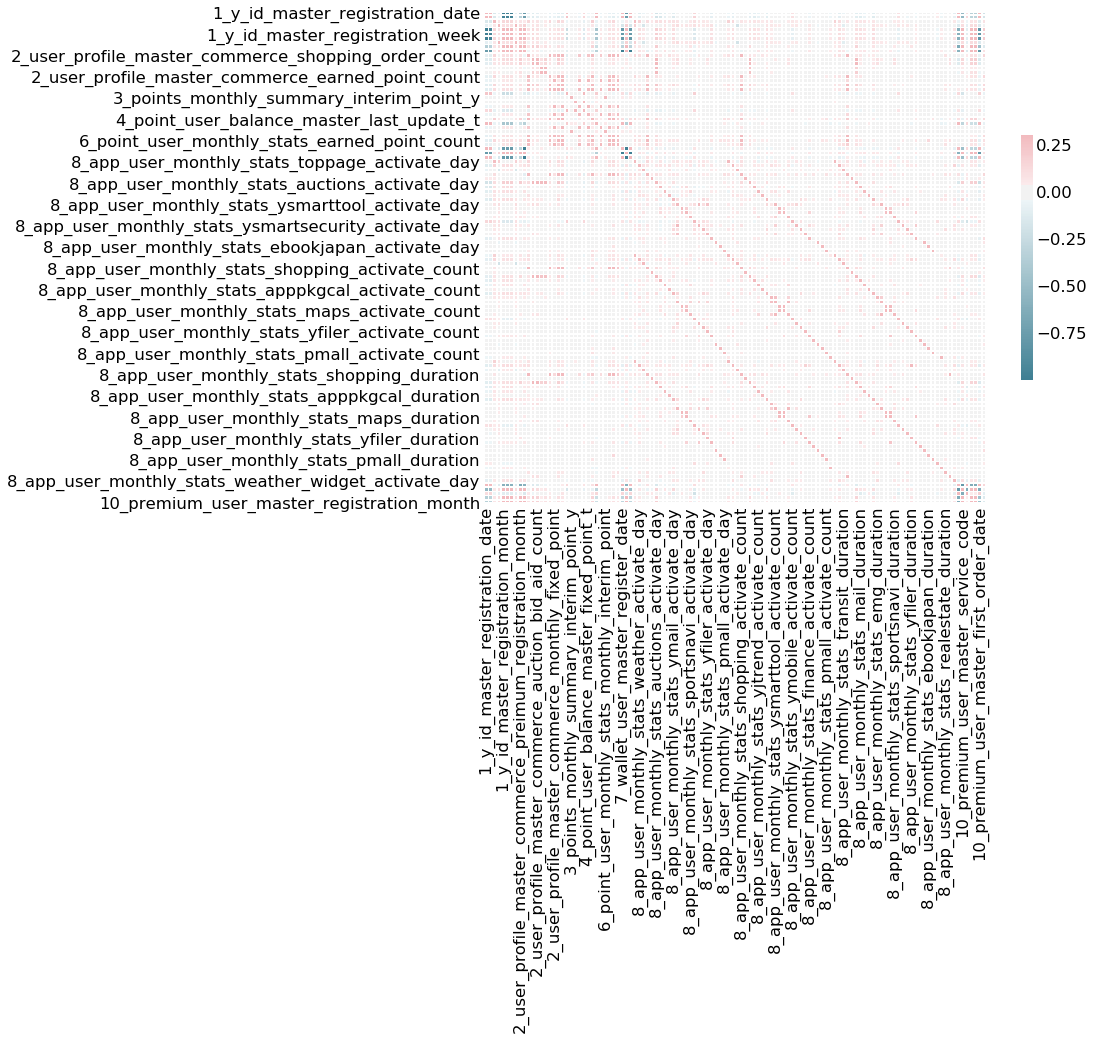

In [23]:
vd = DenseVisualizer(train=X_train, test=X_test, features=dense_features, target=target)
vd.correlation_matrix()

# Categorical features

In [24]:
# EDA for categorical features
vc = CategoricalVisualizer(train=X_train, test=X_test, features=cat_features, target=target)
chkc = vc.column_checker()

feature name = y_id_hex
feature name = 1_y_id_master_gender
feature name = 1_y_id_master_birthday
feature name = 1_y_id_master_chkyj_flag
feature name = 2_user_profile_master_commerce_gender
feature name = 2_user_profile_master_commerce_generation1
feature name = 2_user_profile_master_commerce_generation3
feature name = 2_user_profile_master_commerce_generation5
feature name = 2_user_profile_master_commerce_chkyj_flag
feature name = 2_user_profile_master_commerce_tcard_status
feature name = 2_user_profile_master_commerce_premium_user_flag
feature name = 2_user_profile_master_commerce_premium_segment_id
feature name = 2_user_profile_master_commerce_wallet_registered_flag
feature name = 2_user_profile_master_commerce_valid_card_count
feature name = 2_user_profile_master_commerce_auction_store_flag
feature name = 4_point_user_balance_master_interim_point_y
feature name = 5_tcard_status_master_tcard_status
feature name = 6_point_user_monthly_stats_point_type
feature name = 6_point_user_mon

feature name = 8_app_user_monthly_stats_com_cf_selene_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_realestate_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_minkara_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_com_cf_calendar_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_com_cf_coletto_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_v_assist_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_yfinkeyguardwidget_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_partner_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_com_cfinc_calendar_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_jp_trilltrill_trill_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_yphoto_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_appcover_launcher2_first_activate_date_monthly
feature name = 8_ap

feature name = 8_app_user_monthly_stats_launcher_buzzhome_activate_count
feature name = 8_app_user_monthly_stats_ymsetupman_activate_count
feature name = 8_app_user_monthly_stats_realtime_buzzalert_activate_count
feature name = 8_app_user_monthly_stats_ychiebukuro_activate_count
feature name = 8_app_user_monthly_stats_com_cf_selene_activate_count
feature name = 8_app_user_monthly_stats_realestate_activate_count
feature name = 8_app_user_monthly_stats_minkara_activate_count
feature name = 8_app_user_monthly_stats_com_cf_calendar_activate_count
feature name = 8_app_user_monthly_stats_com_cf_coletto_activate_count
feature name = 8_app_user_monthly_stats_v_assist_activate_count
feature name = 8_app_user_monthly_stats_yfinkeyguardwidget_activate_count
feature name = 8_app_user_monthly_stats_partner_activate_count
feature name = 8_app_user_monthly_stats_com_cfinc_calendar_activate_count
feature name = 8_app_user_monthly_stats_jp_trilltrill_trill_activate_count
feature name = 8_app_user_month

feature name = 8_app_user_monthly_stats_weather_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_transit_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_shopping_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_gyao_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_auctions_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_mail_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_yjtrend_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_apppkgcal_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_ymail_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_emg_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_ysmarttool_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_ybrowser_last_widget_activate_date_monthly
feature name = 8_app

In [25]:
chkc.style.background_gradient()

In [26]:
# remove features with too many nans
cat_features = chkc.loc[chkc["train_nans"] < 1000, "features"].values.tolist()
print(cat_features)

['y_id_hex', '1_y_id_master_gender', '1_y_id_master_chkyj_flag', '2_user_profile_master_commerce_gender', '2_user_profile_master_commerce_generation1', '2_user_profile_master_commerce_generation3', '2_user_profile_master_commerce_generation5', '2_user_profile_master_commerce_chkyj_flag', '2_user_profile_master_commerce_tcard_status', '2_user_profile_master_commerce_premium_user_flag', '2_user_profile_master_commerce_premium_segment_id', '2_user_profile_master_commerce_wallet_registered_flag', '2_user_profile_master_commerce_valid_card_count', '2_user_profile_master_commerce_auction_store_flag', '4_point_user_balance_master_interim_point_y', '5_tcard_status_master_tcard_status', '6_point_user_monthly_stats_point_type', '6_point_user_monthly_stats_earned_limited_point', '6_point_user_monthly_stats_used_point_count', '6_point_user_monthly_stats_invalid_ypoint', '6_point_user_monthly_stats_invalid_ypoint_count', '7_wallet_user_master_wallet_registered_flag', '7_wallet_user_master_gender', 

# Fit LGB and Get Feature importance

In [27]:
for f in features:
    if X_train[f].dtype == "bool":
        X_train[f] = X_train[f].astype(int)
        X_test[f] = X_test[f].astype(int)
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

In [28]:
# label encoding object features
train, test = label_encoding(X_train, X_test, cat_features)
train.head()

,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,1_y_id_master_chkyj_flag,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,18.0,1.0,NaN,20030216,20080701.0,20191201,38.0,202,876,0.0,...,NaN,NaN,NaN,NaN,0.022498,NaN,NaN,NaN,0.013953,0.002430
1,220.0,1.0,NaN,20150111,20150116.0,20191119,28.0,59,255,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93.0,1.0,NaN,20170212,20170217.0,20191130,53.0,34,146,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005941
3,184.0,1.0,NaN,20080810,20080814.0,20191201,39.0,136,590,0.0,...,NaN,NaN,NaN,NaN,NaN,0.026999,NaN,NaN,NaN,NaN
4,17.0,2.0,NaN,20170611,20170617.0,20191201,46.0,30,129,0.0,...,NaN,0.035332,NaN,NaN,NaN,0.006862,NaN,0.032296,NaN,NaN


In [29]:
train[target].isna().sum()

0

In [30]:
test[target].isna().sum()

0

In [31]:
features = dense_features + cat_features
target in features

False

In [33]:
# fit LGB
lgbcls = LgbClassifier(train, test, target, features, categoricals=cat_features, ids="y_id_hex", cv_method="GroupKFold")

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# plot feature importance
lgbcls.plot_feature_importance(rank_range=[1,20])